In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [3]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [4]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps, rec_strength=4.0)

In [5]:
cache_states = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Run Task (with learning)

In [6]:
model.reset()
cache_acts = []
cache_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 10
Now I just cached at location: 20
Now I just cached at location: 30
Now I just cached at location: 40
Now I just cached at location: 50
Now I just cached at location: 60
Now I just cached at location: 70
Now I just cached at location: 80


In [7]:
_, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)

In [8]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

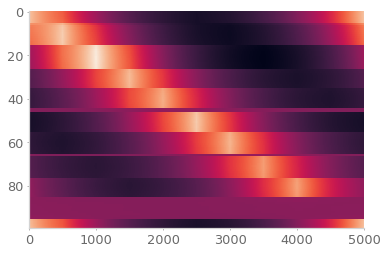

In [9]:
plt.figure()
plt.imshow(output, aspect='auto')
plt.show()

# Define cache activity as a mean over some time window

In [10]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][steps+model.seed_steps-1, location, :]#.mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [11]:
cache_mean = avg_cache_acts.mean(axis=0)

In [12]:
avg_retrieval_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = retrieval_acts_over_time[steps-1, location, :]#.mean(axis=0)
    avg_retrieval_acts.append(vec)
avg_retrieval_acts = np.array(avg_retrieval_acts)

In [13]:
def nb(mu, std_scaling=1.0, mu_scaling=0.75, shift=0.0):
#def nb(mu, std_scaling=2.0, mu_scaling=0.2, shift=0.0):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8 + shift
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    nb_mu = nbinom.rvs(n, p)
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Fig 3ab, Fig 4: cache v. visit correlation

In [14]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}
cache_retrieval_corr = {'Distance': [], 'Correlation': []}
std_scaling = 1

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        retrieval_act_j = avg_retrieval_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(3): # More samples
            c_c_corr = nb_corr(cache_act_i, cache_act_j)
            c_v_corr = nb_corr(cache_act_i, place_act_j)
            v_v_corr = nb_corr(place_act_i, place_act_j)
            c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)
            
            cache_retrieval_corr['Distance'].append(_distance)
            cache_retrieval_corr['Correlation'].append(c_r_corr)


In [15]:
# cc

In [16]:
ccc = pd.DataFrame(cache_cache_corr)
ccc = ccc[ccc['Distance']==0]
print(ccc)

     Distance  Correlation
0           0     0.514091
1           0     0.477605
2           0     0.468672
27          0     0.470157
28          0     0.481945
29          0     0.459661
51          0     0.480263
52          0     0.486847
53          0     0.470423
72          0     0.518418
73          0     0.480632
74          0     0.471836
90          0     0.456213
91          0     0.462765
92          0     0.474602
105         0     0.473390
106         0     0.535202
107         0     0.484034
117         0     0.526706
118         0     0.496578
119         0     0.474047
126         0     0.504897
127         0     0.495697
128         0     0.519096
132         0     0.543130
133         0     0.495936
134         0     0.473383


In [17]:
np.mean(ccc)

Distance       0.000000
Correlation    0.488749
dtype: float64

In [18]:
# cr

In [19]:
crc = pd.DataFrame(cache_retrieval_corr)
crc = crc[crc['Distance']==0]
print(crc)

     Distance  Correlation
0           0     0.549767
1           0     0.528044
2           0     0.529348
27          0     0.476757
28          0     0.523655
29          0     0.496442
51          0     0.462391
52          0     0.498096
53          0     0.569740
72          0     0.507689
73          0     0.580134
74          0     0.589634
90          0     0.534600
91          0     0.503469
92          0     0.543430
105         0     0.538739
106         0     0.578118
107         0     0.591611
117         0     0.565152
118         0     0.569053
119         0     0.569157
126         0     0.486847
127         0     0.543138
128         0     0.525770
132         0     0.556366
133         0     0.567459
134         0     0.514562


In [20]:
np.mean(crc)

Distance       0.000000
Correlation    0.537006
dtype: float64

In [21]:
# vv

In [22]:
vvc = pd.DataFrame(visit_visit_corr)
vvc = vvc[vvc['Distance']==0]

In [23]:
np.mean(vvc)

Distance       0.000000
Correlation    0.225832
dtype: float64

# Plot

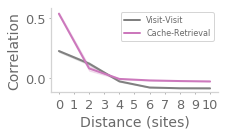

In [29]:
plt.figure(figsize=(3.25,2.))
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(visit_visit_corr),
    color='gray', label='Visit-Visit', linewidth=2.)
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(cache_retrieval_corr),
    color='C4', label='Cache-Retrieval', linewidth=2.)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel('Distance (sites)')
plt.yticks([0., 0.5])
plt.tight_layout()
plt.savefig('c_r_corr.png', dpi=300)
plt.show()